In [1]:
from itertools import chain
from random import random

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

from society.action import Action
from society.agent import Agent
from society.simulations.adaptive import AdaptiveSimulation
from society.agents.constant import AllC, AllD
from society.agents.qlearning import TabularQLearner, DoubleTabularQLearner
from society.agents.random import Random
from society.agents.tft import TitForTat
from society.visualisation.network import *

plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
def generate_population(population):
    agents = [
        DoubleTabularQLearner(lookback=2, epsilon=0.1, learning_rate=0.05, discount_factor=0.99)
        for _ in range(population)
    ]

    G = nx.complete_graph(population)

    weights_matrix = np.zeros((population, population))
    for u, v, d in G.edges(data=True):
        weights_matrix[u, v] = weights_matrix[v, u] = 1
        try:
            d["weight"] = weights_matrix[u, v]
        except:
            d["weight"] = 0

    return agents, weights_matrix, G

In [3]:
# _, _, G = generate_population(32)

# nx.draw(G, pos=nx.spring_layout(G), font_color="white", with_labels=True)

In [4]:
def compute_policies(agents):
    policies = [
        agent._q_table.argmax(axis=-1)
        if hasattr(agent, "_q_table") else None
        for agent in agents
    ]

    return [
        "".join(
            [
                ("C", "D")[policy[i, j]]
                for i in range(4)
                for j in range(4)
                # for k in range(4)
            ]
        )
        if policy is not None else "OTHER"
        for policy in policies
    ]

def calculate_cooperativeness(history):
    count = history.count(Action.COOPERATE)

    return count / len(history)

In [5]:
PAYOFF_LABELS = ["(C, C)", "(C, D)", "(D, C)", "(D, D)"]
# PAYOFF_LABELS = ["R", "S", "T", "P"]

Run 1:   0%|          | 0/6000 [00:00<?, ?it/s]

BEST AGENT (215): 36644 (0.9478834951456311, CCCCCCCCCCCCDCCC)
WORST AGENT (56): 27411 (0.5184756019054976, DCDCCDCCCCCCDCCC)


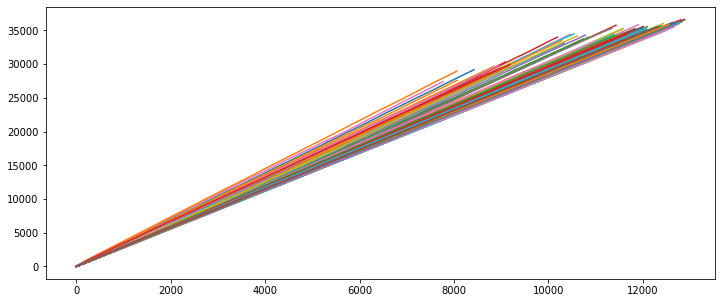

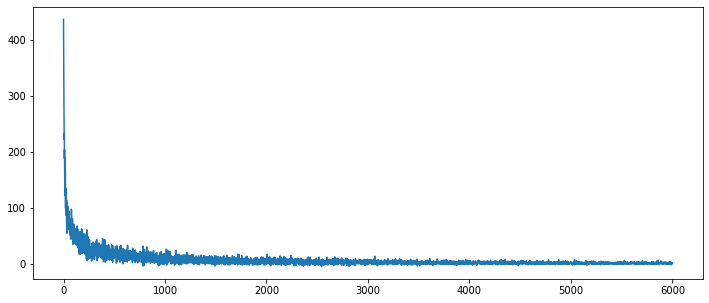

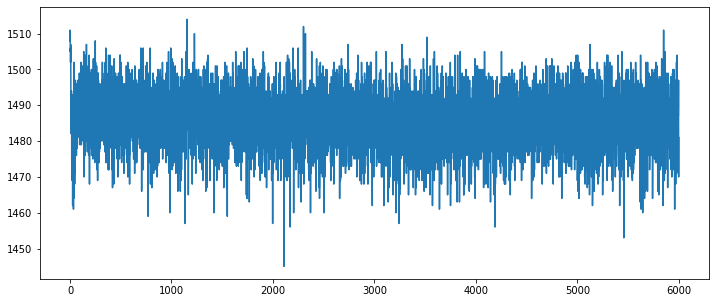

In [6]:
POPULATION = (256,)
ROUNDS = 6_000

run_rewards = []
run_cumulative_rewards = []
run_reward_histories = []
run_policies = []

for run in range(1):
    epoch_rewards = []

    # Generate a new population
    agents, weights_matrix, G = generate_population(*POPULATION)

    # Run a number of rounds
    sim = AdaptiveSimulation(agents, weights_matrix)

    # Run the simulation
    sim.reset()
    for i in tqdm(range(ROUNDS), desc=f"Run {run + 1}"):
        r = sim.play_round(train=True)
        epoch_rewards.append(r)

    # Store results
    run_rewards.append(sim.rewards)
    # run_action_histories.append(sim.action_histories)
    run_reward_histories.append(sim.reward_histories)
    run_policies.append(compute_policies(agents))

    # Output statistics for the best and worst agents
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(sim.reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    tqdm.write(
        f"BEST AGENT ({cumulative_rewards[0][0]}): {cumulative_rewards[0][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[0][0]])))}, {run_policies[-1][cumulative_rewards[0][0]]})"
    )
    tqdm.write(
        f"WORST AGENT ({cumulative_rewards[-1][0]}): {cumulative_rewards[-1][1]} ({calculate_cooperativeness(list(chain(*sim.action_histories[cumulative_rewards[-1][0]])))}, {run_policies[-1][cumulative_rewards[-1][0]]})"
    )

    for rh in sim.reward_histories:
        plt.plot(np.cumsum(rh))
    
    plt.show()

    plt.plot(sim.differences)
    plt.show()

    plt.plot(epoch_rewards)
    plt.show()


In [7]:
G = nx.from_numpy_matrix(np.matrix(sim.produce_weight_matrix()), create_using=nx.DiGraph)

In [8]:
from datetime import datetime

dt = datetime.isoformat(datetime.now()).replace(":", "-").replace("T", " ")

nx.drawing.nx_pydot.write_dot(G, f"{dt}.dot")

In [9]:
# plot_matrix(sim.frequencies, digits=0, figsize=(60, 36))

In [10]:
weights = sim.calculate_weights()

weights

array([[0.05      , 0.25      , 0.27854938, ..., 0.22145329, 0.22437673,
        0.21777778],
       [0.25      , 0.05      , 0.89572704, ..., 0.83063612, 0.7744    ,
        0.88581315],
       [0.27854938, 0.89572704, 0.05      , ..., 0.79283168, 0.89049792,
        0.86411426],
       ...,
       [0.22145329, 0.83063612, 0.79283168, ..., 0.05      , 0.65368945,
        0.72376921],
       [0.22437673, 0.7744    , 0.89049792, ..., 0.65368945, 0.05      ,
        1.        ],
       [0.21777778, 0.88581315, 0.86411426, ..., 0.72376921, 1.        ,
        0.05      ]])

In [11]:
K = nx.Graph()
K.add_weighted_edges_from([
    (i, j, weights[i, j] + weights[j, i])
    for i in range(POPULATION[0])
    for j in range(i + 1, POPULATION[0])
    if i != j and weights[i, j] > 0.7 and weights[j, i] > 0.7
])

nx.drawing.nx_pydot.write_dot(K, f"{dt} - reduced.dot")

In [12]:
sim.action_histories[0][2]

[<Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>,
 <Action.COOPERATE: 0>,
 <Action.DEFECT: 1>]

In [13]:
cumulative_rewards[0][0]

215

In [14]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.86002257e+02 2.20812406e+02]
  [2.60588806e+02 3.22405282e+01]
  [2.49049602e+02 1.49555219e+01]
  [3.46656667e+01 5.00000000e-02]]

 [[2.77241366e+02 8.28570794e+01]
  [1.89025137e+02 4.07378707e+00]
  [9.90914986e+01 3.59425277e+00]
  [6.78708873e+00 2.50000000e-01]]

 [[2.72674481e+02 7.98210139e+01]
  [1.73019129e+02 2.58657549e+00]
  [7.12997752e+01 3.00000000e-01]
  [4.40108735e+00 0.00000000e+00]]

 [[3.62192339e+00 9.95921268e+01]
  [3.40562073e+01 0.00000000e+00]
  [4.92345808e+00 0.00000000e+00]
  [6.38704963e-01 0.00000000e+00]]]


In [15]:
agents[cumulative_rewards[4][0]].play_move([Action.COOPERATE, Action.COOPERATE], [Action.COOPERATE, Action.COOPERATE])

<Action.COOPERATE: 0>

In [16]:
if hasattr(agents[1], "_q_table"):
    print(agents[1]._q_table)

[[[291.46140642 213.57019877]
  [254.74115621  23.19313988]
  [239.6121972   10.94784709]
  [ 42.88119023   1.47457931]]

 [[276.64534422 103.60443179]
  [172.01200639   5.30296432]
  [ 86.90755305   1.58847805]
  [  2.01142372   0.        ]]

 [[275.18078256  33.26881331]
  [161.57317061   3.49583021]
  [ 59.48983393   1.21618581]
  [  7.79132454   0.        ]]

 [[125.38004448   4.01694463]
  [ 61.49481838   0.        ]
  [ 15.12327535   0.        ]
  [  0.           0.        ]]]


In [17]:
# from datetime import datetime
# import pickle

# with open(f"results - {datetime.isoformat(datetime.now()).replace(':', '-')}.pickle", "wb") as f:
#     pickle.dump({
#         "rewards": run_rewards,
#         "cumulative_rewards": run_cumulative_rewards,
#         # "action_histories": run_action_histories,
#         "reward_histories": run_reward_histories,
#         "policies": run_policies,
#     }, f)


In [18]:
cumulative_reward_policy_ranks = {}
cumulative_reward_policies = {}

for policies, reward_histories in zip(run_policies, run_reward_histories):
    cumulative_rewards = [(i, sum(history)) for i, history in enumerate(reward_histories)]
    cumulative_rewards.sort(key=lambda x: x[1], reverse=True)

    for rank, (i, cumulative_reward) in enumerate(cumulative_rewards):
        policy = policies[i]

        if policy not in cumulative_reward_policy_ranks:
            cumulative_reward_policy_ranks[policy] = []
            cumulative_reward_policies[policy] = []

        cumulative_reward_policy_ranks[policy].append(rank + 1)
        cumulative_reward_policies[policy].append(cumulative_reward)

mean_cumulative_reward_policy_ranks = {policy: np.mean(ranks) for policy, ranks in cumulative_reward_policy_ranks.items()}
mean_cumulative_reward_policies = {policy: np.mean(rewards) for policy, rewards in cumulative_reward_policies.items()}

In [19]:
for policy in sorted(mean_cumulative_reward_policy_ranks, key=lambda x: mean_cumulative_reward_policy_ranks[x]):
    print(f"{mean_cumulative_reward_policy_ranks[policy]:<24} {policy}")

13.0                     CCCCCCCCCCCDDCCC
16.0                     CCCCCDCCCDCCDCCC
19.666666666666668       CCCCCCCCCCCCCCCD
36.5                     CCCCCCDCCCCCCCCC
37.0                     CCCCCCCDCCCDDCCC
42.0                     CCCCCCCCCCCCDDCC
43.0                     CCCCCCCCCDCDCCCC
52.0                     CCCCCCCDCCCCCCDC
54.0                     CCDCCCCCDCCCCCDC
57.0                     CCCDCCCCCCCCDCCC
59.0                     CCCDCCCCCCDCCCCC
70.66666666666667        CCCDCCCDCCCCCCCC
74.0                     CCCCCCDCCCCCCCDC
74.28571428571429        CCCDCCCCCCCCCCCC
75.0                     CCCDDDCCCCCCCCCC
76.5                     CCCDCCCCCCCDCCCC
77.0                     CCCCCCCDCCCCCCCD
82.28571428571429        CCCCCDCCCCCCCCCC
84.0                     CCDCCCCDCCCCCDCC
84.5                     CCCCCCCCDCCCCCCC
86.33333333333333        CCCCCCCCCCCCCCDC
97.25                    CCCCCCCCCCCCCDCC
97.42857142857143        CCCCCCCCCCCCDCCC
97.5                     CCCCCCCDC

In [20]:
for policy in sorted(mean_cumulative_reward_policies, key=lambda x: mean_cumulative_reward_policies[x], reverse=True):
    print(f"{mean_cumulative_reward_policies[policy]:<24} {policy}")

36324.0                  CCCCCCCCCCCDDCCC
36188.0                  CCCCCDCCCDCCDCCC
36160.0                  CCCCCCCCCCCCCCCD
35950.5                  CCCCCCDCCCCCCCCC
35899.0                  CCCCCCCDCCCDDCCC
35854.0                  CCCCCCCCCCCCDDCC
35843.0                  CCCCCCCCCDCDCCCC
35778.0                  CCCCCCCDCCCCCCDC
35773.0                  CCDCCCCCDCCCCCDC
35736.0                  CCCDCCCCCCCCDCCC
35722.0                  CCCDCCCCCCDCCCCC
35673.57142857143        CCCCCDCCCCCCCCCC
35663.0                  CCCCCCCCCCCCCCDC
35659.28571428572        CCCDCCCCCCCCCCCC
35642.333333333336       CCCDCCCDCCCCCCCC
35610.5                  CCCDCCCCCCCDCCCC
35596.0                  CCCCCCDCCCCCCCDC
35592.0                  CCCDDDCCCCCCCCCC
35590.5                  CCCCCCCDCCCCCDCC
35587.0                  CCCCCCCDCCCCCCCD
35566.0                  CCCCCCCCDCCCCCCC
35561.0                  CCDCCCCDCCCCCDCC
35549.28571428572        CCCCCCCCCCCCDCCC
35466.32183908046        CCCCCCCCC

In [21]:
compute_policies([agents[cumulative_rewards[0][0]]])[0]

'CCCCCCCCCCCCDCCC'

In [22]:
if hasattr(agents[cumulative_rewards[0][0]], "_q_table"):
    print(agents[cumulative_rewards[0][0]]._q_table)

[[[2.86002257e+02 2.20812406e+02]
  [2.60588806e+02 3.22405282e+01]
  [2.49049602e+02 1.49555219e+01]
  [3.46656667e+01 5.00000000e-02]]

 [[2.77241366e+02 8.28570794e+01]
  [1.89025137e+02 4.07378707e+00]
  [9.90914986e+01 3.59425277e+00]
  [6.78708873e+00 2.50000000e-01]]

 [[2.72674481e+02 7.98210139e+01]
  [1.73019129e+02 2.58657549e+00]
  [7.12997752e+01 3.00000000e-01]
  [4.40108735e+00 0.00000000e+00]]

 [[3.62192339e+00 9.95921268e+01]
  [3.40562073e+01 0.00000000e+00]
  [4.92345808e+00 0.00000000e+00]
  [6.38704963e-01 0.00000000e+00]]]


In [23]:
from itertools import product

P = compute_policies([agents[cumulative_rewards[0][0]]])[0]

for m, p in zip(product(PAYOFF_LABELS, PAYOFF_LABELS), P):
    print(m, "=>", p)

('(C, C)', '(C, C)') => C
('(C, C)', '(C, D)') => C
('(C, C)', '(D, C)') => C
('(C, C)', '(D, D)') => C
('(C, D)', '(C, C)') => C
('(C, D)', '(C, D)') => C
('(C, D)', '(D, C)') => C
('(C, D)', '(D, D)') => C
('(D, C)', '(C, C)') => C
('(D, C)', '(C, D)') => C
('(D, C)', '(D, C)') => C
('(D, C)', '(D, D)') => C
('(D, D)', '(C, C)') => D
('(D, D)', '(C, D)') => C
('(D, D)', '(D, C)') => C
('(D, D)', '(D, D)') => C
